In [1]:
import pandas as pd
df = pd.read_excel('Airbnb_data.xlsx')
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74105 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [12]:
# Data Exploration and Preprocessing 
# handling missing values
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute missing values for numerical columns with the median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Impute missing values for categorical columns with the mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Check if any missing values remain
print(df.isnull().sum())
df.info()

C:\Users\anish\AppData\Local\Temp\ipykernel_15968\3903068083.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


id                        0
log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
description               0
first_review              0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
last_review               0
latitude                  0
longitude                 0
name                      0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
thumbnail_url             0
zipcode                   0
bedrooms                  0
beds                      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------  

<Axes: >

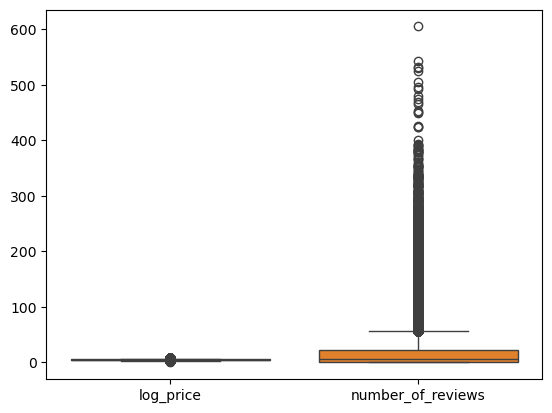

In [14]:
#Outlier Detection
import seaborn as sns
sns.boxplot(data=df[['log_price', 'number_of_reviews']])


In [41]:
#Feature Engineering
# Step 1: Handle non-string values in 'amenities' column and count amenities
def count_amenities(amenities):
    # If 'amenities' is NaN or None, return 0
    if pd.isna(amenities) or amenities is None:
        return 0
    # If 'amenities' is a string, proceed to split by commas and count the number of amenities
    if isinstance(amenities, str):
        return len(amenities.split(','))
    # If 'amenities' is a list, return the length of the list
    elif isinstance(amenities, list):
        return len(amenities)
    # For other data types (like floats, integers), return 0
    return 0

# Apply the function to the 'amenities' column to count amenities
df['num_amenities'] = df['amenities'].apply(count_amenities)

# Step 2: Location-Based Popularity
# Let's calculate the popularity of each location based on the number of listings in each neighbourhood or city.
# Assuming the 'neighbourhood' column exists in the dataset.
location_popularity = df['neighbourhood'].value_counts()
df['location_popularity'] = df['neighbourhood'].map(location_popularity)

# Step 3: Handle any missing values for the new features
df['num_amenities'] = df['num_amenities'].fillna(0)  # Fill missing amenities count with 0
df['host_response_rate'] = df['host_response_rate'].fillna(0)  # If no response rate, assume 0
df['location_popularity'] = df['location_popularity'].fillna(0)  # If no data for location, assume 0

# Step 4: Final dataset check
print(df[['num_amenities', 'host_response_rate', 'location_popularity']].head())


   num_amenities  host_response_rate  location_popularity
0              9                 1.0                  111
1             15                 1.0                 1299
2             19                 1.0                 1374
3             15                 1.0                  124
4             12                 1.0                  298


In [30]:
# Model Development
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Convert datetime columns to numerical features
# Assuming the datetime column is named 'date_column'
if 'date_column' in df.columns:
    df['date_column'] = pd.to_datetime(df['date_column'])
    df['year'] = df['date_column'].dt.year
    df['month'] = df['date_column'].dt.month
    df['day'] = df['date_column'].dt.day
    df = df.drop('date_column', axis=1)

# Step 2: Ensure all categorical columns are in string format
# For example, if there are any categorical columns with mixed types, convert them to string
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].astype(str)

# Step 3: Define features and target
X = df.drop('log_price', axis=1)  # Assuming 'price' is the target variable
y = df['log_price']

# Step 4: One-Hot Encoding with sparse output
encoder = OneHotEncoder(sparse_output=True, drop='first')
X_encoded = encoder.fit_transform(X)

# Step 5: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 6: Train LightGBM Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.386229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7544
[LightGBM] [Info] Number of data points in the train set: 59288, number of used features: 3772
[LightGBM] [Info] Start training from score 4.780538
RMSE: 0.4081013926997078
MAE: 0.29925671907040713
R²: 0.6758062087441525


C:\Users\anish\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


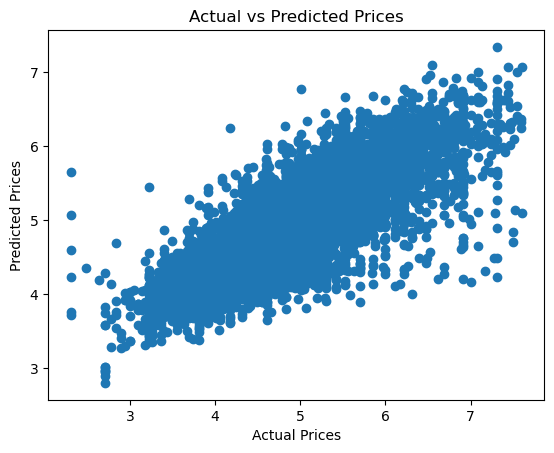

In [31]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()
